In [3]:
import numpy as np
import matplotlib.pyplot as plt
import book_plots

In [7]:
def plot_g_h_results (measurements, filtered_data, title=''):
    plt.plot (filtered_data, '--',label='filter')
    plt.plot(measurements,label='measurement')
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

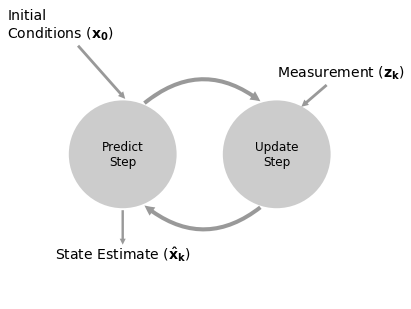

In [4]:
book_plots.predict_update_chart()

We can express this as an algorithm:

**Initialization**

1. Initialize the state of the filter
2. Initialize our belief in the state

**Predict**

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

**Update**

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. New estimate is somewhere on the residual line

We will use this same algorithm throughout the book, albeit with some modifications.

$$\begin{gathered}
  {x_p}\left( k \right) = {x_s}\left( {k - 1} \right) + \Delta x\left( {k - 1} \right) \cdot \Delta T \hfill \\
  \Delta x\left( k \right) = \Delta x\left( {k - 1} \right) \hfill \\
  res = {x_o}\left( k \right) - {x_p}\left( k \right) \hfill \\
  {x_s}\left( k \right) = {x_p}\left( k \right) + g \cdot res \hfill \\
  \Delta x\left( k \right) = \Delta x\left( k \right) + \left( {{h \mathord{\left/
 {\vphantom {h {\Delta T}}} \right.
 \kern-\nulldelimiterspace} {\Delta T}}} \right) \cdot res \hfill \\ 
\end{gathered} 
$$

In [5]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

#### Performs g-h filter on 1 state variable with a fixed $g$ and $h$.

In [9]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    'pred' is an optional list. If provided, each prediction will be stored in it
    """
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

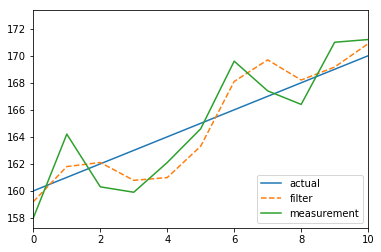

In [16]:
plt.xlim([0,10])
plt.plot([0,10],[160,170],label='actual')
data = g_h_filter (data=weights, x0=160, dx=1, g=6./10, h = 2./3, dt=1.)
plot_g_h_results (weights, data)